Interactively test the spherical Voronoi algorithm implementation proposed by Ross Hemsley at PyData London 2015

In [62]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import voronoi_utility
import numpy as np
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
#pre-requisite step: generate the random coordinates on the sphere
prng = np.random.RandomState(117)
random_coordinate_array = voronoi_utility.generate_random_array_spherical_generators(1000,1.0,prng)

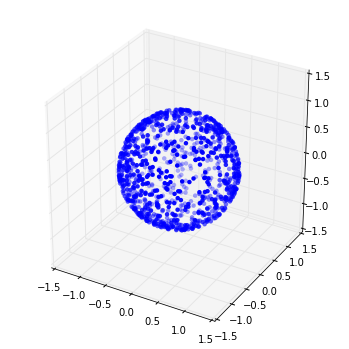

In [64]:
#confirm reasonable distribution of points on the unit sphere
fig_initial_sphere = plt.figure()
ax = fig_initial_sphere.add_subplot('111', projection = '3d')
ax.scatter(random_coordinate_array[...,0], random_coordinate_array[...,1], random_coordinate_array[...,2], c = 'blue', edgecolor = 'none')
fig_initial_sphere.set_size_inches(6,6)

In [65]:
#step 1: place an additional generator at the centre of the sphere (the origin of the coordinate system)
random_coordinate_array = np.concatenate((random_coordinate_array, np.zeros((1,3))))
random_coordinate_array[-5:,...]

array([[ 0.81325255, -0.10395777, -0.57254962],
       [ 0.45141247, -0.58900654,  0.67029701],
       [-0.629159  , -0.77472842, -0.06288739],
       [-0.44992442,  0.10452284,  0.88692897],
       [ 0.        ,  0.        ,  0.        ]])

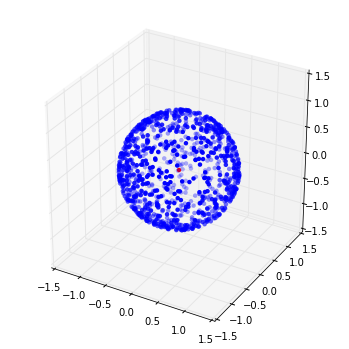

In [66]:
#confirm appropriate coordinates for the center (in red)
fig_additional_generator = plt.figure()
ax = fig_additional_generator.add_subplot('111', projection = '3d')
ax.scatter(random_coordinate_array[:-1,0], random_coordinate_array[:-1,1], random_coordinate_array[:-1,2], c = 'blue', edgecolor = 'none')
ax.scatter(random_coordinate_array[-1,0], random_coordinate_array[-1,1], random_coordinate_array[-1,2], c = 'red', edgecolor = 'none')
fig_additional_generator.set_size_inches(6,6)

In [67]:
#step 2: perform 3D Delaunay triangulation on data set that includes the extra generator
tri = sp.spatial.Delaunay(random_coordinate_array)

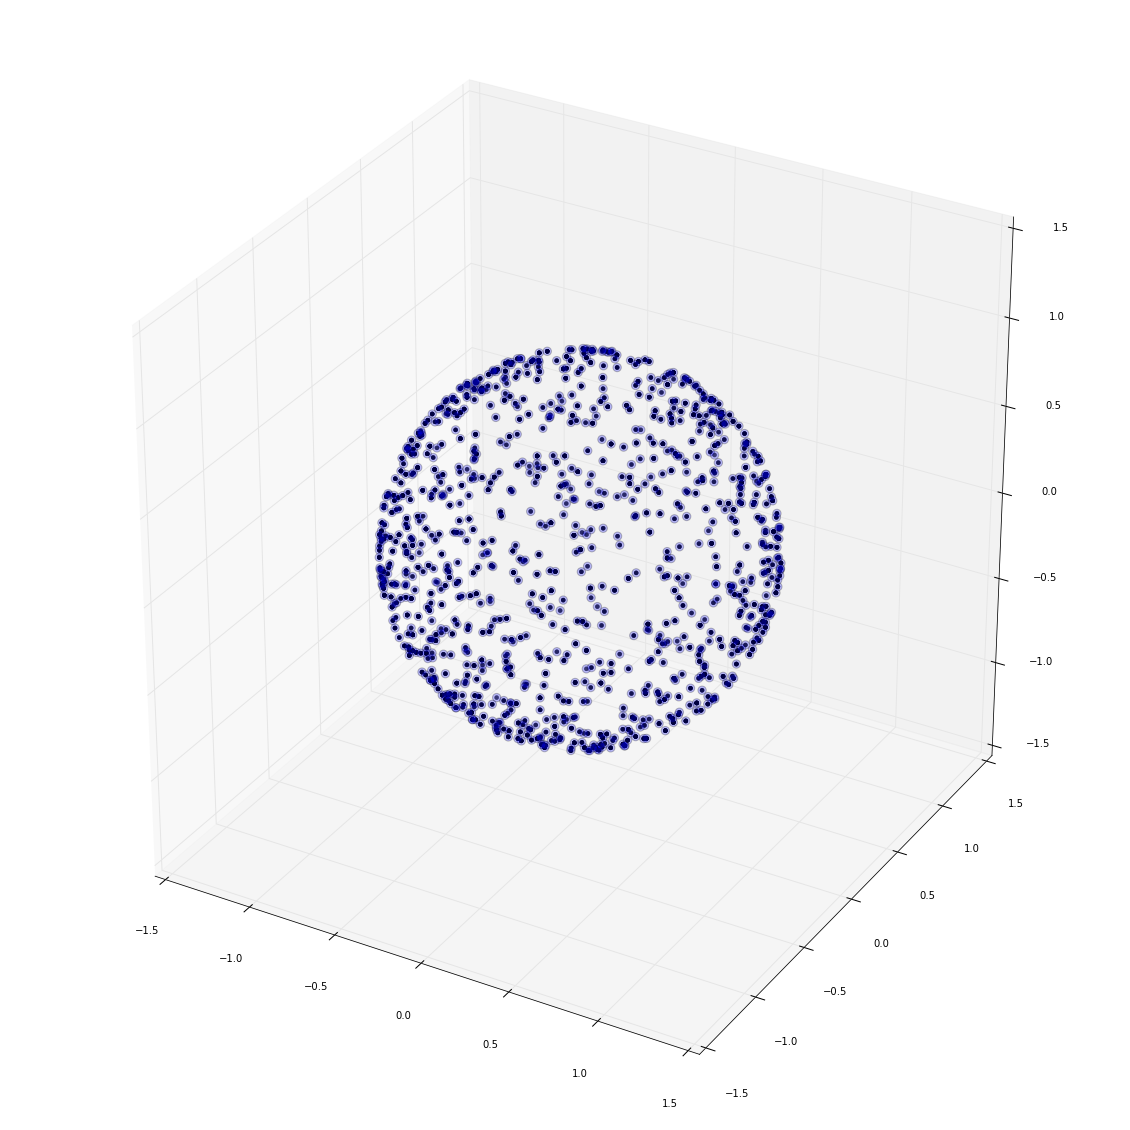

In [68]:
#confirm reasonable-looking tetrahedralization of sphere
fig_initial_tetrahedralization = plt.figure()
ax = fig_initial_tetrahedralization.add_subplot('111', projection = '3d')
for simplex in tri.points[tri.simplices]:
    ax.scatter(simplex[...,0], simplex[...,1], simplex[...,2], c = 'k', edgecolor = 'none')
ax.scatter(random_coordinate_array[...,0], random_coordinate_array[...,1], random_coordinate_array[...,2], c = 'blue', edgecolor = 'none', s = 70, alpha = 0.25)
fig_initial_tetrahedralization.set_size_inches(20,20)

Although connecting the tetrahedra in a non-intersecting fashion would probably be a bit more work, the superposition of generators on the tetrahedral vertices is sensible given that each generator should indeed be a vertex in the 3D tetrahedralization.

In [116]:
#step 3a: produce circumspheres / circumcenters of tetrahedra from 3D Delaunay
#based on some rough testing, it turns out that ALL simplices (tetrahedra) have one vertex at the origin [I think Ross was trying to explain this to me at PyData London 2015]
#the unit normal to the outer Delaunay facet (on sphere surface) is a Voronoi vertex (as in my previous algorithm)
#because each tetrahedron contains the origin as a vertex, the circumcenter is located halfway between the origin and the Voronoi vertex [othwerise the other vertices would illegally be located inside the circumsphere]
#furthermore, if we exclude the tetrahedral vertex at the origin, the remaining three vertices form a face (triangle) on the sphere surface, the circumcenter of which may be projected to the sphere surface to produce the coordinates of the corresponding Voronoi vertex

import circumcircle

list_circumcenter_coordinates = []
for simplex in tri.points[tri.simplices]: #iterate over tetrahedra
    #need to find circumcenter of tetrahedron circumsphere
    tetrahedron_circumsphere_circumcenter = circumcircle.calc_circumcenter_circumsphere_tetrahedron_2(simplex)
    list_circumcenter_coordinates.append(tetrahedron_circumsphere_circumcenter)
    
array_circumcenter_coords = np.array(list_circumcenter_coordinates)
    
    
    

In [117]:
array_circumcenter_coords.shape

(1996, 3)

In [118]:
array_circumcenter_coords

array([[-0.26579721,  0.3158127 , -0.29206454],
       [-0.38607866,  0.26836967,  0.17417512],
       [-0.25290039,  0.35967617,  0.24814029],
       ..., 
       [-0.05847558, -0.34502138,  0.35752067],
       [-0.01743171, -0.36129696,  0.34650686],
       [-0.01695518, -0.354884  ,  0.35305303]])

In [122]:
#I'm pretty sure the circumcenter coords should fall within the unit sphere because the circumsphere of the simplex should not contain any generators
#do some isolated plotting to test this out 

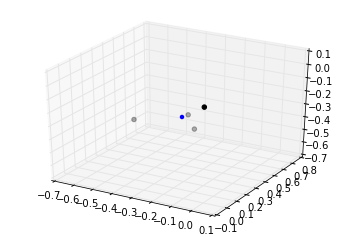

In [123]:
first_tetrahedron = tri.points[tri.simplices][0]
first_tetrahedron
first_circumcenter = circumcircle.calc_circumcenter_circumsphere_tetrahedron_2(first_tetrahedron)
fig_test_circumcenter = plt.figure()
ax = fig_test_circumcenter.add_subplot('111', projection = '3d')
ax.scatter(first_tetrahedron[...,0], first_tetrahedron[...,1], first_tetrahedron[...,2], c = 'k')
ax.scatter(first_circumcenter[...,0], first_circumcenter[...,1], first_circumcenter[...,2], c= 'blue', edgecolor = 'none')

In [124]:
#ok, the circumcenter of circumsphere calculation is now starting to look more reasonable with the new implementation

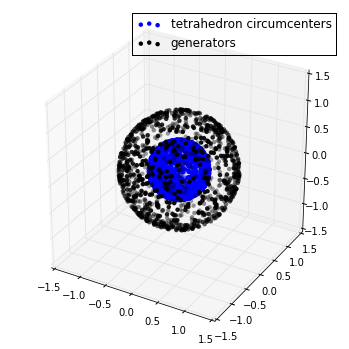

In [127]:
#plot the full set of circumcenter coordinates to confirm that they are all looking reasonable relative to the generators
fig_test_all_circumcenters = plt.figure()
ax = fig_test_all_circumcenters.add_subplot('111', projection = '3d')
ax.scatter(array_circumcenter_coords[...,0], array_circumcenter_coords[...,1], array_circumcenter_coords[...,2], c = 'blue', edgecolor = 'none', label = 'tetrahedron circumcenters')
ax.scatter(random_coordinate_array[...,0], random_coordinate_array[...,1], random_coordinate_array[...,2], c = 'black', edgecolor = 'none', label = 'generators')
ax.legend()
fig_test_all_circumcenters.set_size_inches(6,6)

In [137]:
#attempt to project the tetrahedron circumcenters up to the surface of the sphere, to produce the Voronoi vertices
# based on http://stackoverflow.com/a/9604279
radius = 1.0
array_vector_lengths = sp.spatial.distance.cdist(array_circumcenter_coords,np.zeros((1,3)))
array_Voronoi_vertices = (radius / np.abs(array_vector_lengths)) * array_circumcenter_coords


In [138]:
array_Voronoi_vertices.shape

(1996, 3)

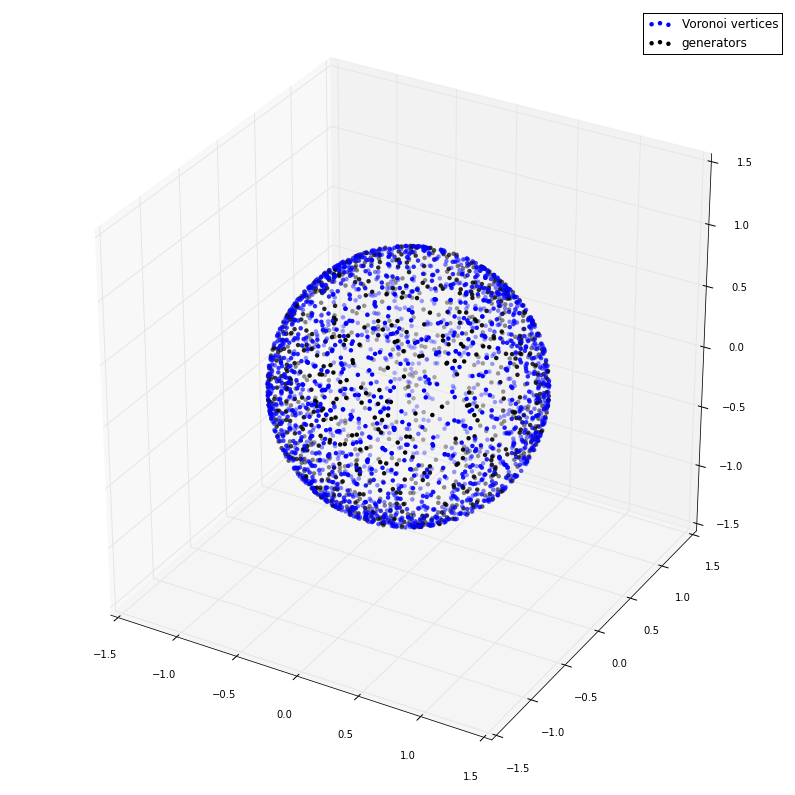

In [139]:
#confirm reasonable positions for Voronoi vertices relative to generators by visual inspection:
fig_assess_Voronoi_vertices = plt.figure()
ax = fig_assess_Voronoi_vertices.add_subplot('111', projection = '3d')
ax.scatter(array_Voronoi_vertices[...,0], array_Voronoi_vertices[...,1], array_Voronoi_vertices[...,2], c = 'blue', edgecolor = 'none', label = 'Voronoi vertices')
ax.scatter(random_coordinate_array[...,0], random_coordinate_array[...,1], random_coordinate_array[...,2], c = 'black', edgecolor = 'none', label = 'generators')
ax.legend()
fig_assess_Voronoi_vertices.set_size_inches(14,14)


In [290]:
#attempt to use the Delaunay tetrahedralization neighbour information to connect the Voronoi vertices around the generators (i.e., to produce the Voronoi regions)
#still a work in progress

def filter_tetrahedron_to_triangle(current_tetrahedron_coord_array):
    current_triangle_coord_array = [] #initialize as a list
    for row in current_tetrahedron_coord_array: #ugly to use for loop for this, but ok for now!
        if row[0] == 0 and row[1] == 0 and row[2] == 0: #filter out origin row
            continue
        else:
            current_triangle_coord_array.append(row)
    current_triangle_coord_array = np.array(current_triangle_coord_array)
    return current_triangle_coord_array

array_tetrahedra = tri.points[tri.simplices]
num_generators = len(tri.points) - 1 #don't want to work with the dummy generator at the origin
gen_counter = 0
list_of_sublists_of_tetrahedron_indices_surrounding_each_generator = []

for generator in tri.points[:-1]: #don't want to work with the dummy generator at the origin (which is the last point in the generator set)
    #print 'generator:', generator
    #identify the simplices (tetrahedra minus origin = triangles) that contain a given generator as a vertex
    indices_of_triangles_surrounding_generator = np.unique(np.where(tri.points[tri.simplices] == generator)[0])
    #print 'number of triangles surrounding generator:', len(indices_of_triangles_surrounding_generator)
    #print 'indices_of_triangles_surrounding_generator:', indices_of_triangles_surrounding_generator
    #pick any one of the triangles surrounding the generator and pick a non-generator vertex
    first_tetrahedron_index = indices_of_triangles_surrounding_generator[0]
    first_tetrahedron = array_tetrahedra[first_tetrahedron_index]
    #print 'first_tetrahedron:', first_tetrahedron
    first_triangle = filter_tetrahedron_to_triangle(first_tetrahedron)
    #print 'first_triangle:', first_triangle #first triangle has index 0 in the indices_of_triangles_surrounding_generator
    #pick one of the two non-generator vertices in the first triangle
    indices_non_generator_vertices_first_triangle = np.unique(np.where(first_triangle != generator)[0])
    #print 'indices_non_generator_vertices_first_triangle:', indices_non_generator_vertices_first_triangle
    
    ordered_list_tetrahedron_indices_surrounding_current_generator = [first_tetrahedron_index] 
    
    #determine the appropriate ordering of Voronoi vertices to close the Voronoi region (polygon) by traversing the Delaunay neighbour data structure from scipy
    vertices_remaining = len(indices_of_triangles_surrounding_generator) - 1
    #choose the neighbour opposite the first non-generator vertex of the first triangle
    neighbour_tetrahedral_index = tri.neighbors[first_tetrahedron_index][indices_non_generator_vertices_first_triangle[0]]
    #print 'neighbour_tetrahedral_index:', neighbour_tetrahedral_index
    ordered_list_tetrahedron_indices_surrounding_current_generator.append(neighbour_tetrahedral_index)
    #print 'ordered_list_tetrahedron_indices_surrounding_current_generator:', ordered_list_tetrahedron_indices_surrounding_current_generator
    vertices_remaining -= 1
    
    #for all subsequent triangles it is the common non-generator vertex with the previous neighbour that should be used to propagate the connection chain to the following neighbour
    #the common vertex with the previous neighbour is the the vertex of the previous neighbour that was NOT used to locate the current neighbour
    #since there are only two candidate vertices on the previous neighbour and I've chosen to use the vertex with index 0, the remaining vertex on the previous neighbour is the non-generator vertex with index 1
    common_vertex_coordinate = first_triangle[indices_non_generator_vertices_first_triangle[1]]
    #print 'first common_vertex_coordinate:', common_vertex_coordinate
    while vertices_remaining > 0:
        #print 'common_vertex_coordinate:', common_vertex_coordinate
        current_tetrahedron_index = ordered_list_tetrahedron_indices_surrounding_current_generator[-1]
        current_tetrahedron_coord_array = array_tetrahedra[current_tetrahedron_index]
        #it seems that it is not quite guaranteed that the last row of the tetrahedron is the origin point (though this is usually the case) -- will need a more robust filter to remove the origin and produce the relevant triangular simplex
        current_triangle_coord_array = filter_tetrahedron_to_triangle(current_tetrahedron_coord_array)
        #print 'current_triangle_coord_array:', current_triangle_coord_array
        #print 'current_tetrahedron_coord_array', current_tetrahedron_coord_array
        indices_candidate_vertices_current_triangle_excluding_generator = np.unique(np.where(current_triangle_coord_array != generator)[0])
        #print 'indices_candidate_vertices_current_triangle_excluding_generator:', indices_candidate_vertices_current_triangle_excluding_generator
        array_candidate_vertices = current_triangle_coord_array[indices_candidate_vertices_current_triangle_excluding_generator]
        #if len(indices_candidate_vertices_current_triangle_excluding_generator) > 2:
        #    print 'violating array:', array_candidate_vertices
        #    print 'generator', generator
        #    print 'current_triangle_coord_array', current_triangle_coord_array
        #    print 'current_tetrahedron_coord_array', current_tetrahedron_coord_array
        #print 'array_candidate_vertices:', array_candidate_vertices
        #print 'current_tetrahedron_coord_array:', current_tetrahedron_coord_array
        current_tetrahedron_index_for_neighbour_propagation = np.unique(np.where(current_tetrahedron_coord_array == common_vertex_coordinate)[0])
        #print 'current_tetrahedron_index_for_neighbour_propagation:', current_tetrahedron_index_for_neighbour_propagation
        next_tetrahedron_index_surrounding_generator = tri.neighbors[current_tetrahedron_index][current_tetrahedron_index_for_neighbour_propagation][0]
        if next_tetrahedron_index_surrounding_generator == -1: #debug -- trying to deal with case of 'boundary' simplex -- whatever that means on the sphere!!
            #print 'problematic array_candidate_vertices:', array_candidate_vertices
            #print 'related common_vertex_coordinate:', common_vertex_coordinate
            full_list_neighbour_indices_current_tetrahedron = tri.neighbors[current_tetrahedron_index]
            for neighbour_index in full_list_neighbour_indices_current_tetrahedron:
                if neighbour_index != -1 and neighbour_index not in ordered_list_tetrahedron_indices_surrounding_current_generator:
                    next_tetrahedron_index_surrounding_generator = neighbour_index
        #print 'next_tetrahedron_index_surrounding_generator:', next_tetrahedron_index_surrounding_generator
        common_vertex_coordinate = array_candidate_vertices[array_candidate_vertices != common_vertex_coordinate] #for the next iteration
        ordered_list_tetrahedron_indices_surrounding_current_generator.append(next_tetrahedron_index_surrounding_generator)
        #print 'ordered_list_tetrahedron_indices_surrounding_current_generator:', ordered_list_tetrahedron_indices_surrounding_current_generator
        vertices_remaining -= 1
    list_of_sublists_of_tetrahedron_indices_surrounding_each_generator.append(ordered_list_tetrahedron_indices_surrounding_current_generator)
    gen_counter += 1
    print 'generator', gen_counter, 'of', num_generators

generator 1 of 1000
generator 2 of 1000
generator 3 of 1000
generator 4 of 1000
generator 5 of 1000
generator 6 of 1000
generator 7 of 1000
generator 8 of 1000
generator 9 of 1000
generator 10 of 1000
generator 11 of 1000
generator 12 of 1000
generator 13 of 1000
generator 14 of 1000
generator 15 of 1000
generator 16 of 1000
generator 17 of 1000
generator 18 of 1000
generator 19 of 1000
generator 20 of 1000
generator 21 of 1000
generator 22 of 1000
generator 23 of 1000
generator 24 of 1000
generator 25 of 1000
generator 26 of 1000
generator 27 of 1000
generator 28 of 1000
generator 29 of 1000
generator 30 of 1000
generator 31 of 1000
generator 32 of 1000
generator 33 of 1000
generator 34 of 1000
generator 35 of 1000
generator 36 of 1000
generator 37 of 1000
generator 38 of 1000
generator 39 of 1000
generator 40 of 1000
generator 41 of 1000
generator 42 of 1000
generator 43 of 1000
generator 44 of 1000
generator 45 of 1000
generator 46 of 1000
generator 47 of 1000
generator 48 of 1000
g

[[-0.35963455  0.16525321  0.91834327]
 [-0.37405408  0.11836398  0.91982255]
 [-0.46530628  0.06476555  0.88277714]
 [-0.50211722  0.08889887  0.86021816]
 [-0.46863676  0.15046071  0.87048329]
 [-0.39790958  0.17871525  0.89984933]]


(0.0, 0.4)

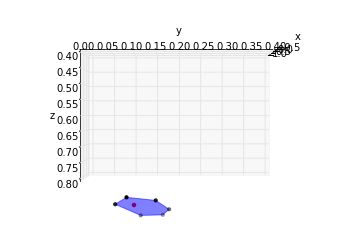

In [291]:
#plot to confirm that the above algorithm is working for a single generator and its surrounding Voronoi vertices:
fig_test_ordering_single_voronoi_polygon = plt.figure()
ax = fig_test_ordering_single_voronoi_polygon.add_subplot('111', projection = '3d')
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
voronoi_region_vertices_ordered = array_Voronoi_vertices[ordered_list_tetrahedron_indices_surrounding_current_generator]
print voronoi_region_vertices_ordered
polygon = Poly3DCollection([voronoi_region_vertices_ordered], alpha = 0.5)
polygon.set_color('blue')
ax.add_collection3d(polygon)
ax.scatter(voronoi_region_vertices_ordered[...,0], voronoi_region_vertices_ordered[...,1], voronoi_region_vertices_ordered[...,2], c = 'k', s = 10)
ax.scatter(generator[...,0], generator[...,1], generator[...,2], c= 'red', edgecolor = 'none')
ax.azim = 0
ax.elev = -180
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim((0.4,0.8))
ax.set_ylim((0.0,0.4))

So, I appear to have successfully constructed the Voronoi cell for the first generator using the algorithm Ross proposed, with proper ordering of Voronoi vertices. Now need to produce the overall spherical Voronoi diagram and probably also select a subset of the Voronoi regions for visual inspection in this manner.

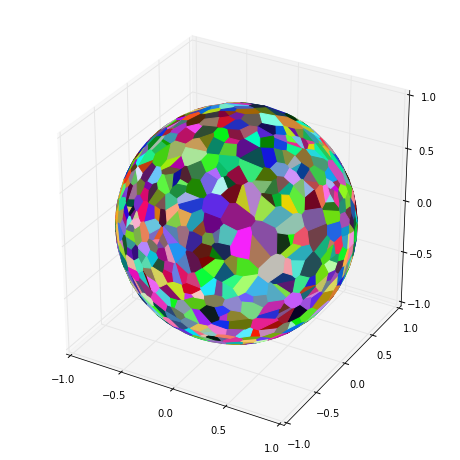

In [295]:
#plot the spherical Voronoi diagram
fig_spherical_Voronoi = plt.figure()
ax = fig_spherical_Voronoi.add_subplot('111', projection = '3d')
import matplotlib.colors as colors
for list_tetrahedron_indices_around_current_generator in list_of_sublists_of_tetrahedron_indices_surrounding_each_generator:
    random_color = colors.rgb2hex(sp.rand(3))
    current_voronoi_region_vertices_ordered = array_Voronoi_vertices[list_tetrahedron_indices_around_current_generator]
    polygon = Poly3DCollection([current_voronoi_region_vertices_ordered], alpha = 1.0)
    polygon.set_color(random_color)
    ax.add_collection3d(polygon)
    
ax.set_xlim((-1,1))
ax.set_ylim((-1,1))
ax.set_zlim((-1,1))
fig_spherical_Voronoi.set_size_inches(8,8)

In [297]:
#check that the surface area reconstituted from the full set of Voronoi polygons is close to the theoretical surface area of the a unit sphere:
total_surface_area = 0
for list_tetrahedron_indices_around_current_generator in list_of_sublists_of_tetrahedron_indices_surrounding_each_generator:
    current_voronoi_region_vertices_ordered = array_Voronoi_vertices[list_tetrahedron_indices_around_current_generator]
    total_surface_area += voronoi_utility.calculate_surface_area_of_a_spherical_Voronoi_polygon(current_voronoi_region_vertices_ordered, 1.0)

import math
theoretical_surface_area = 4.0 * math.pi 
print 'total_surface_area', total_surface_area
print 'theoretical_surface_area', theoretical_surface_area
print 'percent surface area reconstitution:', (total_surface_area / theoretical_surface_area) * 100.

total_surface_area 12.5663706144
theoretical_surface_area 12.5663706144
percent surface area reconstitution: 100.0


Can't get any better than that!

In [298]:
#just to be absolutely sure, up next I'll want to plot a subset of the Voronoi regions and their associated generators, but I can't imagine there are any self-intersecting Voronoi polygons now that we have full reconstitution

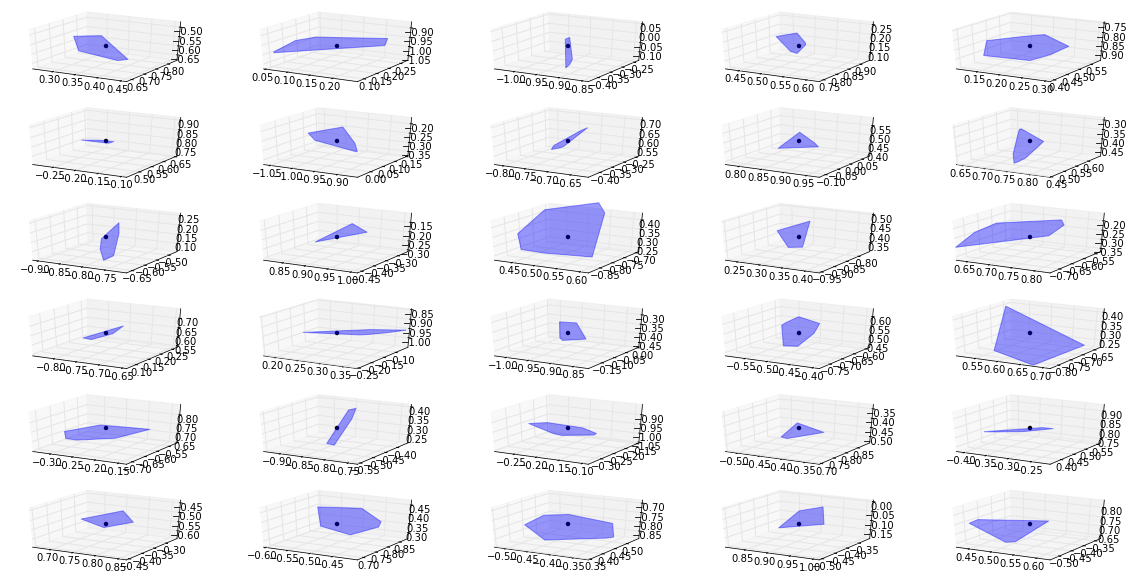

In [311]:
fig_panel_zoom_voronoi_regions = plt.figure()
subplot_number = 1
array_random_indices = np.random.randint(random_coordinate_array.shape[0], size = 30)
for generator_index in array_random_indices:
    ax = fig_panel_zoom_voronoi_regions.add_subplot(6,5,subplot_number, projection = '3d')
    list_tetrahedron_indices_around_current_generator = list_of_sublists_of_tetrahedron_indices_surrounding_each_generator[generator_index]
    current_voronoi_region_vertices_ordered = array_Voronoi_vertices[list_tetrahedron_indices_around_current_generator]
    generator = random_coordinate_array[generator_index]
    ax.scatter(generator[...,0], generator[...,1], generator[...,2], c= 'k', edgecolor = 'none')
    polygon = Poly3DCollection([current_voronoi_region_vertices_ordered], alpha = 0.4)
    polygon.set_color('blue')
    ax.add_collection3d(polygon)
    ax.set_xlim((generator[...,0].min() - 0.1, generator[...,0].max() + 0.1))
    ax.set_ylim((generator[...,1].min() - 0.1, generator[...,1].max() + 0.1))
    ax.set_zlim((generator[...,2].min() - 0.1, generator[...,2].max() + 0.1))
    subplot_number += 1
    
    
fig_panel_zoom_voronoi_regions.set_size_inches(20,10)

The results look excellent -- I don't see any indication of issues with the randomly-selected Voronoi regions, after accounting for 3D perspectives, etc.